In [1]:
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

from torchvision.datasets.utils import download_url
import zipfile

C:\Users\muaaz\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Download and extract COCO dataset
def download_coco():
    print("Downloading COCO validation images...")
    download_url(
        "http://images.cocodataset.org/zips/val2017.zip",
        ".",
        "val2017.zip",
        None
    )
    
    print("Downloading COCO annotations...")
    download_url(
        "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
        ".",
        "annotations_trainval2017.zip",
        None
    )
    
    # Extract files
    print("Extracting files...")
    with zipfile.ZipFile("val2017.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    with zipfile.ZipFile("annotations_trainval2017.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

download_coco()

100%|████████████████████████████████████████████████████████████████████████████████| 816M/816M [26:28<00:00, 513kB/s]


 72%|███████████████████████████████████████████████████████                      | 181M/253M [1:18:33<36:15, 33.0kB/s]

In [3]:
# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
image_folder = "val2017"

# Load all image file names
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".jpg")]

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
# Function to extract image features
def extract_image_features(image_paths):
    image_features = []
    processed_images = []
    
    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        processed_image = transform(image).unsqueeze(0)  # Convert to tensor
        processed_images.append(processed_image)

    # Stack all images and process in batches
    batch_images = torch.cat(processed_images, dim=0)
    with torch.no_grad():
        image_embeds = model.get_image_features(pixel_values=batch_images)
    
    image_embeds /= image_embeds.norm(dim=-1, keepdim=True)  # Normalize
    return image_embeds, image_paths

# Extract image features
image_features, image_paths = extract_image_features(image_paths)

In [8]:
# Function to find top 5 similar images
def find_similar_images(query):
    inputs = processor(text=[query], return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_embeds = model.get_text_features(**inputs)
    
    text_embeds /= text_embeds.norm(dim=-1, keepdim=True)  # Normalize
    
    # Compute cosine similarity
    similarities = (text_embeds @ image_features.T).squeeze(0).cpu().numpy()
    
    # Get top 5 images
    top5_indices = similarities.argsort()[-5:][::-1]
    top5_paths = [image_paths[i] for i in top5_indices]
    top5_scores = [similarities[i] for i in top5_indices]

    return top5_paths, top5_scores

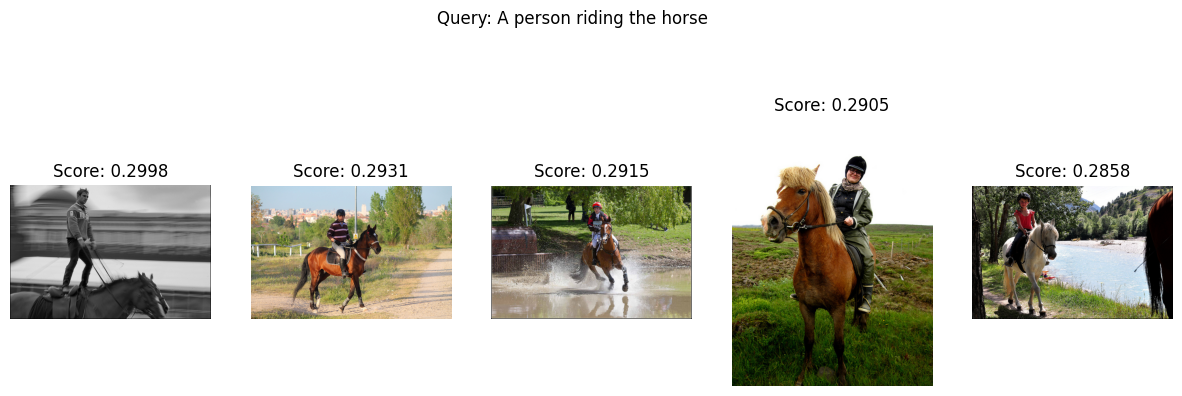

In [9]:
query = "A person riding the horse"
top_images, scores = find_similar_images(query)

# Display results
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img_path, score) in enumerate(zip(top_images, scores)):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Score: {score:.4f}")

plt.suptitle(f"Query: {query}")
plt.show()
